In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

In [5]:
df = pd.read_csv("./covid_19_data.csv", parse_dates = ['ObservationDate', "Last Update"])

In [6]:
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
306424,306425,2021-05-29,Zaporizhia Oblast,Ukraine,2021-05-30 04:20:55,102641.0,2335.0,95289.0
306425,306426,2021-05-29,Zeeland,Netherlands,2021-05-30 04:20:55,29147.0,245.0,0.0
306426,306427,2021-05-29,Zhejiang,Mainland China,2021-05-30 04:20:55,1364.0,1.0,1324.0
306427,306428,2021-05-29,Zhytomyr Oblast,Ukraine,2021-05-30 04:20:55,87550.0,1738.0,83790.0


In [7]:
df.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

In [8]:
#Tirando letras maiúsculas e caracteres especiais dos nomes das colunas
import re

def corrige_nomes(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

In [10]:
df.columns = [corrige_nomes(col) for col in df.columns]
df.columns

Index(['sno', 'observationdate', 'provincestate', 'countryregion',
       'lastupdate', 'confirmed', 'deaths', 'recovered'],
      dtype='object')

In [13]:
#Pegando os dados do Brasil
br = df.loc[(df['countryregion'] == 'Brazil')&
            (df['confirmed'] > 0)]
br

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
2525,2526,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2631,2632,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2742,2743,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2852,2853,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
2981,2982,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
306272,306273,2021-05-29,Roraima,Brazil,2021-05-30 04:20:55,103222.0,1635.0,96188.0
306290,306291,2021-05-29,Santa Catarina,Brazil,2021-05-30 04:20:55,965277.0,15174.0,921496.0
306292,306293,2021-05-29,Sao Paulo,Brazil,2021-05-30 04:20:55,3254893.0,111123.0,2895697.0
306298,306299,2021-05-29,Sergipe,Brazil,2021-05-30 04:20:55,233932.0,5054.0,208146.0


In [43]:
#Fazendo um gráfico dos casos confirmados do Brasil
px.line(br, 'observationdate', 'confirmed', title = 'Casos confirmados no Brasil')

In [26]:
#Os dados a partir do dia 19/05/2020 se dividem por estado, vamos somar os dados em cada dia.

br2 = br.groupby('observationdate', as_index = False).sum()

In [28]:
#Fazendo um gráfico dos casos confirmados do Brasil
px.line(br2, 'observationdate', 'confirmed', title = 'Casos confirmados no Brasil')

In [30]:
#Fazendo um gráfico de novos casos do Brasil
br2['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else br2['confirmed'].iloc[x] - br2['confirmed'].iloc[x-1],
    np.arange(br2.shape[0])
))

In [31]:
px.line(br2, 'observationdate', 'novoscasos', title = 'Novos casos no Brasil')

In [34]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=br2.observationdate, y=br2.deaths, name = 'Mortes', mode = 'lines+markers', line = {'color':'red'})
)


#Layout
fig.update_layout(title = 'Mortes por COVID-19 no Brasil')

fig.show()

In [40]:
#Taxa de crescimento
def taxa_crescimento(data, variable, data_inicio = None, data_fim = None):
    #Se data início for None, pegamos a primeira data disponível
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable]>0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
    #Se fata fim for None, pegamos o ultimo dado disponível
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    #Definimos os valores da variavel no início e no fim
    inicio = data.loc[data.observationdate == data_inicio, variable].values[0]
    fim = data.loc[data.observationdate == data_fim, variable].values[0]
    
    #Define o número de dias que se passaram no período
    n = (data_fim - data_inicio).days
    
    #Calcular a taxa
    taxa = (fim/inicio)**(1/n) - 1
    
    return taxa*100

In [41]:
taxa_crescimento(br2, 'confirmed')

3.694820710228286

In [44]:
def taxa_crescimento_diaria(data, variable, data_inicio = None):
#Se data início for None, pegamos a primeira data disponível
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable]>0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observationdate.max()
#Define o número de dias que se passaram no período
    n = (data_fim - data_inicio).days
#Taxa calculada de um dia para outro
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1, n+1)
    ))
    return np.array(taxas)*100
    

In [45]:
tx_dia = taxa_crescimento_diaria(br2, 'confirmed')

In [46]:
primeiro_dia = br2.observationdate.loc[br2.confirmed > 0].min()

px.line(x=pd.date_range(primeiro_dia, br2.observationdate.max())[1:],
       y=tx_dia, title = 'Taxa de crescimento de casos confirmados no Brasil')

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [50]:
confirmados = br2.confirmed
confirmados.index = br2.observationdate
confirmados

observationdate
2020-02-26           1.0
2020-02-27           1.0
2020-02-28           1.0
2020-02-29           2.0
2020-03-01           2.0
                 ...    
2021-05-25    16194209.0
2021-05-26    16274695.0
2021-05-27    16342162.0
2021-05-28    16391930.0
2021-05-29    16471600.0
Name: confirmed, Length: 459, dtype: float64

In [51]:
res = seasonal_decompose(confirmados)

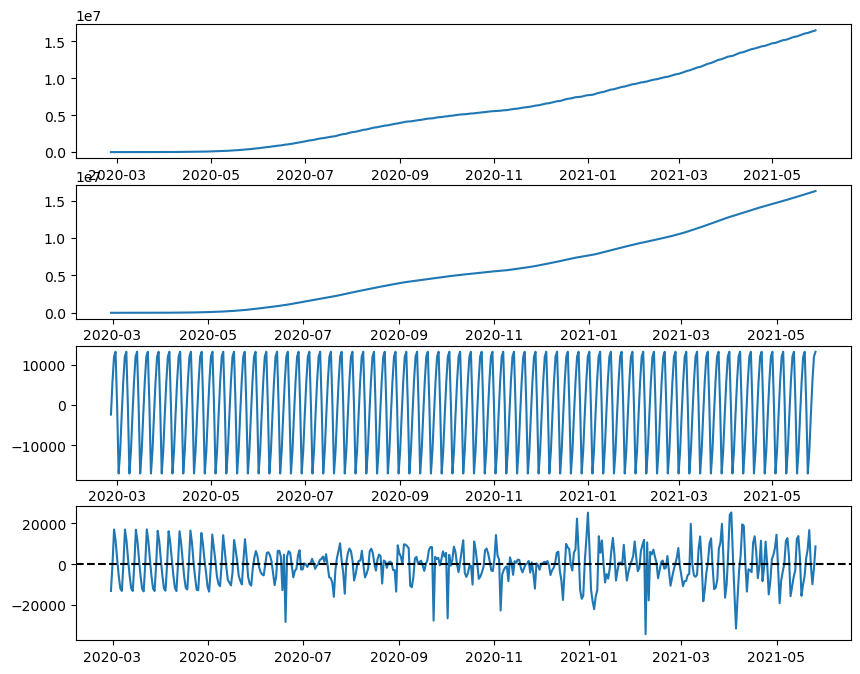

In [53]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10,8))

ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.plot(confirmados.index, res.resid)
ax4.axhline(0, linestyle = 'dashed', c ='black')
plt.show()

In [54]:
!pip install pmdarima

In [55]:
from pmdarima.arima import auto_arima
modelo = auto_arima(confirmados)


In [58]:
fig = go.Figure(go.Scatter(
    x = confirmados.index, y = confirmados, name='Observados'))

fig.add_trace(go.Scatter(
    x=confirmados.index, y=modelo.predict_in_sample(), name='Preditos'))

fig.add_trace(go.Scatter(
    x=pd.date_range('2021-05-30', '2022-06-30'), y=modelo.predict(31),name='Forecast'))

fig.update_layout(title = 'Previsão de casos confirmados no Brasil para os próximos 30 dias')

fig.show()